In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt




#  Download the Fashion MNIST dataset

In [2]:


transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

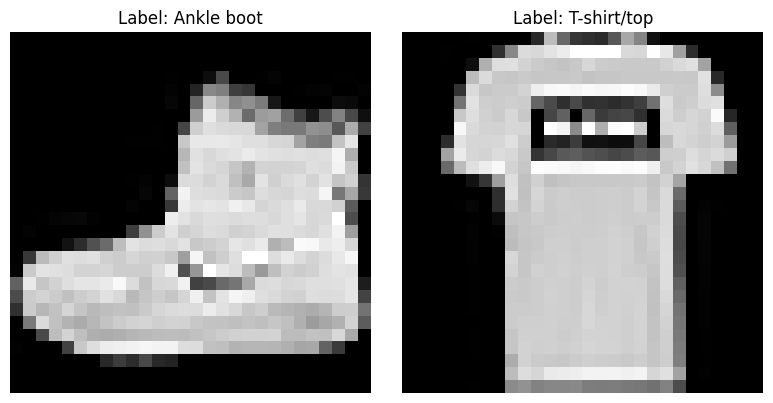

In [3]:

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i in range(2):
    image, label = train_data[i]
    ax[i].imshow(image.squeeze(), cmap='gray')
    ax[i].set_title(f"Label: {train_data.classes[label]}")
    ax[i].axis('off')
plt.tight_layout()
plt.show()


# Perform the Fourier Transform on all data

In [4]:

def fft_transform(data):
    fft_data = []
    for img, _ in data:
        fft = np.fft.fft2(img.numpy().squeeze())
        fft_data.append(fft)
    return np.array(fft_data)

train_fft = fft_transform(train_data)
test_fft = fft_transform(test_data)





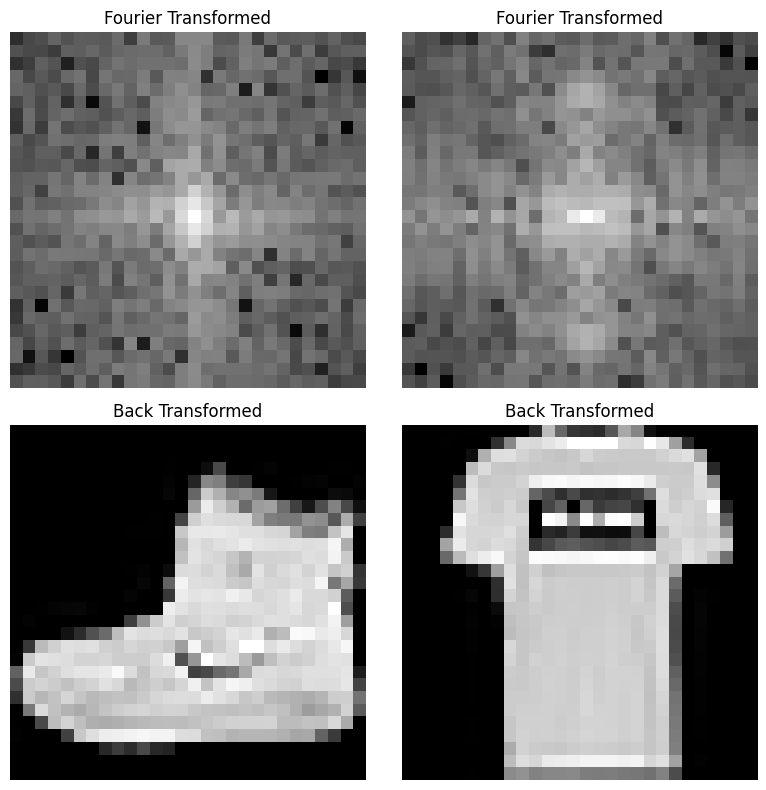

In [5]:
# 4. Plot Fourier transformed and back-transformed examples
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
for i in range(2):
    ax[0, i].imshow(np.log(np.abs(np.fft.fftshift(train_fft[i]))), cmap='gray')
    ax[0, i].set_title("Fourier Transformed")
    ax[0, i].axis('off')
    
    back_transformed = np.fft.ifft2(train_fft[i]).real
    ax[1, i].imshow(back_transformed, cmap='gray')
    ax[1, i].set_title("Back Transformed")
    ax[1, i].axis('off')
plt.tight_layout()
plt.show()

# Create dataset

In [21]:
def create_complex_dataset(data, labels):
    real_data = np.real(data)
    imag_data = np.imag(data)
    complex_data = np.stack((real_data, imag_data), axis=1)
    complex_tensor = torch.from_numpy(complex_data).float()
    label_tensor = torch.tensor(labels)
    print(len(complex_tensor), len(label_tensor))
    return torch.utils.data.TensorDataset(complex_tensor, label_tensor)

train_labels = [label for _, label in train_data]
train_dataset = create_complex_dataset(train_fft, train_labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_labels = [label for _, label in test_data]
test_dataset = create_complex_dataset(test_fft, test_labels)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

print(len(train_loader))

60000 60000
10000 10000
938


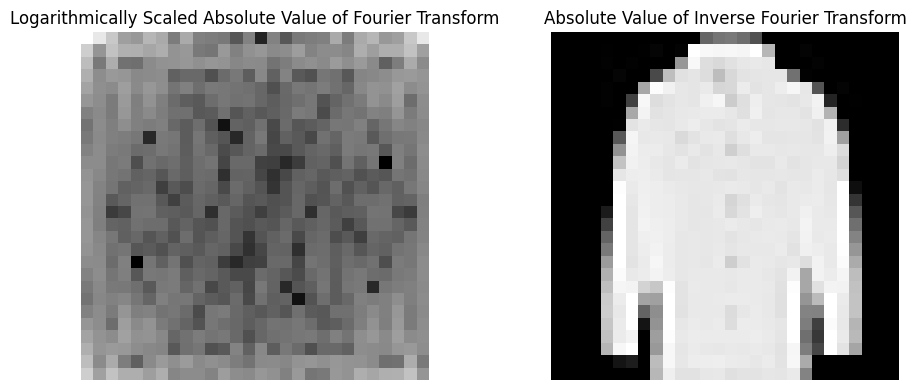

In [17]:
# Load one sample from the test loader
test_sample, test_label = next(iter(test_loader))

# Get the first sample from the batch
test_sample = test_sample[14]
test_sample = torch.complex(test_sample[0], test_sample[1])
# Compute the absolute value and apply logarithmic scaling
abs_fft = torch.abs(test_sample)
log_abs_fft = torch.log(abs_fft + 1e-7)  # Add a small constant to avoid taking log of zero

# Compute the inverse Fourier transform
ifft_sample = torch.fft.ifft2(test_sample)
ifft_abs = torch.abs(ifft_sample)

# Create a new figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot the logarithmically scaled absolute value of the Fourier transform
ax1.imshow(log_abs_fft.squeeze(), cmap='gray')
ax1.set_title("Logarithmically Scaled Absolute Value of Fourier Transform")
ax1.axis('off')

# Plot the absolute value of the inverse Fourier transform
ax2.imshow(ifft_abs.squeeze(), cmap='gray')
ax2.set_title("Absolute Value of Inverse Fourier Transform")
ax2.axis('off')

plt.tight_layout()
plt.show()

# Network Structures

In [24]:
class FourierCNN(nn.Module):
    def __init__(self):
        super(FourierCNN, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)

model = FourierCNN()


# Train Loop

In [29]:
from tqdm import tqdm
# 7. Train the network on the Fourier transformed data
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}", unit="batch")
    for batch_idx, (data, target) in enumerate(progress_bar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        progress_bar.set_postfix({"Train Loss": train_loss / (batch_idx + 1), "Train Acc": 100. * correct / total})
    
    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / total
    return train_loss, train_accuracy

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / total
    return test_loss, test_accuracy


## Start training

In [30]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 60

for epoch in range(1, epochs + 1):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_accuracy = test(model, device, test_loader)
    
    print(f"Epoch {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print()

Epoch 1: 100%|██████████| 938/938 [00:01<00:00, 478.25batch/s, Train Loss=0.0908, Train Acc=97]  


Epoch 1
Train Loss: 0.0908, Train Accuracy: 97.00%
Test Loss: 0.6802, Test Accuracy: 89.69%



Epoch 2: 100%|██████████| 938/938 [00:01<00:00, 514.62batch/s, Train Loss=0.0884, Train Acc=97]  


Epoch 2
Train Loss: 0.0884, Train Accuracy: 96.95%
Test Loss: 0.6332, Test Accuracy: 89.74%



Epoch 3: 100%|██████████| 938/938 [00:01<00:00, 514.32batch/s, Train Loss=0.0874, Train Acc=97]  


Epoch 3
Train Loss: 0.0874, Train Accuracy: 96.98%
Test Loss: 0.6754, Test Accuracy: 89.48%



Epoch 4: 100%|██████████| 938/938 [00:01<00:00, 508.03batch/s, Train Loss=0.089, Train Acc=96.9] 


Epoch 4
Train Loss: 0.0890, Train Accuracy: 96.92%
Test Loss: 0.6980, Test Accuracy: 89.51%



Epoch 5: 100%|██████████| 938/938 [00:01<00:00, 516.00batch/s, Train Loss=0.0912, Train Acc=96.9]


Epoch 5
Train Loss: 0.0912, Train Accuracy: 96.92%
Test Loss: 0.7356, Test Accuracy: 89.48%



Epoch 6: 100%|██████████| 938/938 [00:01<00:00, 521.16batch/s, Train Loss=0.0841, Train Acc=97.1]


Epoch 6
Train Loss: 0.0841, Train Accuracy: 97.09%
Test Loss: 0.6534, Test Accuracy: 89.81%



Epoch 7: 100%|██████████| 938/938 [00:01<00:00, 518.06batch/s, Train Loss=0.0898, Train Acc=96.9]


Epoch 7
Train Loss: 0.0898, Train Accuracy: 96.93%
Test Loss: 0.6685, Test Accuracy: 89.60%



Epoch 8: 100%|██████████| 938/938 [00:01<00:00, 514.26batch/s, Train Loss=0.0872, Train Acc=97]  


Epoch 8
Train Loss: 0.0872, Train Accuracy: 96.96%
Test Loss: 0.6898, Test Accuracy: 89.58%



Epoch 9: 100%|██████████| 938/938 [00:01<00:00, 510.68batch/s, Train Loss=0.0886, Train Acc=96.9]


Epoch 9
Train Loss: 0.0886, Train Accuracy: 96.86%
Test Loss: 0.6864, Test Accuracy: 89.88%



Epoch 10: 100%|██████████| 938/938 [00:01<00:00, 505.97batch/s, Train Loss=0.0869, Train Acc=97]  


Epoch 10
Train Loss: 0.0869, Train Accuracy: 96.97%
Test Loss: 0.6738, Test Accuracy: 89.63%



Epoch 11: 100%|██████████| 938/938 [00:01<00:00, 506.65batch/s, Train Loss=0.0877, Train Acc=97]  


Epoch 11
Train Loss: 0.0877, Train Accuracy: 96.96%
Test Loss: 0.6221, Test Accuracy: 89.43%



Epoch 12: 100%|██████████| 938/938 [00:01<00:00, 511.79batch/s, Train Loss=0.0873, Train Acc=96.9]


Epoch 12
Train Loss: 0.0873, Train Accuracy: 96.94%
Test Loss: 0.7031, Test Accuracy: 89.73%



Epoch 13: 100%|██████████| 938/938 [00:01<00:00, 511.35batch/s, Train Loss=0.0896, Train Acc=96.9]


Epoch 13
Train Loss: 0.0896, Train Accuracy: 96.93%
Test Loss: 0.6550, Test Accuracy: 89.74%



Epoch 14: 100%|██████████| 938/938 [00:01<00:00, 518.61batch/s, Train Loss=0.0856, Train Acc=97.1]


Epoch 14
Train Loss: 0.0856, Train Accuracy: 97.08%
Test Loss: 0.6907, Test Accuracy: 89.39%



Epoch 15: 100%|██████████| 938/938 [00:01<00:00, 509.83batch/s, Train Loss=0.0834, Train Acc=97.2]


Epoch 15
Train Loss: 0.0834, Train Accuracy: 97.17%
Test Loss: 0.6662, Test Accuracy: 89.29%



Epoch 16: 100%|██████████| 938/938 [00:01<00:00, 517.56batch/s, Train Loss=0.0898, Train Acc=97]  


Epoch 16
Train Loss: 0.0898, Train Accuracy: 96.97%
Test Loss: 0.6530, Test Accuracy: 89.59%



Epoch 17: 100%|██████████| 938/938 [00:01<00:00, 509.86batch/s, Train Loss=0.0893, Train Acc=97]  


Epoch 17
Train Loss: 0.0893, Train Accuracy: 97.03%
Test Loss: 0.6506, Test Accuracy: 89.70%



Epoch 18: 100%|██████████| 938/938 [00:01<00:00, 510.54batch/s, Train Loss=0.0877, Train Acc=97]  


Epoch 18
Train Loss: 0.0877, Train Accuracy: 97.01%
Test Loss: 0.7716, Test Accuracy: 89.50%



Epoch 19: 100%|██████████| 938/938 [00:01<00:00, 516.18batch/s, Train Loss=0.0859, Train Acc=97]  


Epoch 19
Train Loss: 0.0859, Train Accuracy: 97.03%
Test Loss: 0.7111, Test Accuracy: 89.65%



Epoch 20: 100%|██████████| 938/938 [00:01<00:00, 509.85batch/s, Train Loss=0.0864, Train Acc=97]  


Epoch 20
Train Loss: 0.0864, Train Accuracy: 97.00%
Test Loss: 0.6808, Test Accuracy: 89.22%



Epoch 21: 100%|██████████| 938/938 [00:01<00:00, 516.29batch/s, Train Loss=0.084, Train Acc=97]   


Epoch 21
Train Loss: 0.0840, Train Accuracy: 97.03%
Test Loss: 0.6725, Test Accuracy: 89.53%



Epoch 22: 100%|██████████| 938/938 [00:01<00:00, 517.02batch/s, Train Loss=0.0817, Train Acc=97.2]


Epoch 22
Train Loss: 0.0817, Train Accuracy: 97.19%
Test Loss: 0.7454, Test Accuracy: 89.53%



Epoch 23: 100%|██████████| 938/938 [00:01<00:00, 512.61batch/s, Train Loss=0.0883, Train Acc=97]  


Epoch 23
Train Loss: 0.0883, Train Accuracy: 97.00%
Test Loss: 0.6721, Test Accuracy: 89.66%



Epoch 24: 100%|██████████| 938/938 [00:01<00:00, 505.87batch/s, Train Loss=0.0874, Train Acc=97]  


Epoch 24
Train Loss: 0.0874, Train Accuracy: 97.01%
Test Loss: 0.7477, Test Accuracy: 89.51%



Epoch 25: 100%|██████████| 938/938 [00:01<00:00, 511.05batch/s, Train Loss=0.087, Train Acc=97]   


KeyboardInterrupt: 

# Evaluation

## Prediction for a single test example

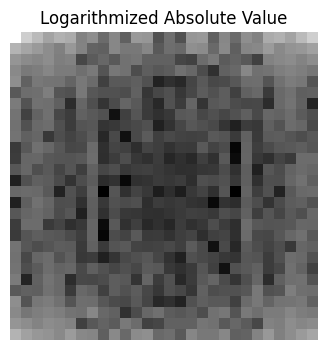

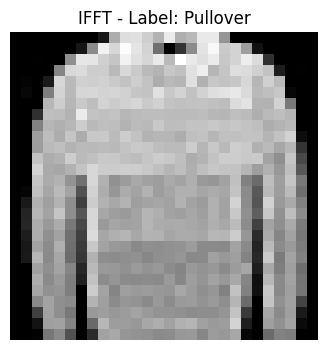

True Label: Pullover
Predicted Label: Pullover


In [34]:
example = 20
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
# Get a single test example
test_sample, test_label = next(iter(test_loader))
test_sample, test_label = test_sample[example], test_label[example]

# Make a complex number out of real and imaginary channels
complex_sample = torch.complex(test_sample[0], test_sample[1])

# Plot the absolute value logarithmized
abs_sample = torch.abs(complex_sample)
log_abs_sample = torch.log(abs_sample + 1e-7)  # Add a small constant to avoid taking log of zero

plt.figure(figsize=(4, 4))
plt.imshow(log_abs_sample.numpy(), cmap='gray')
plt.title("Logarithmized Absolute Value")
plt.axis('off')
plt.show()

# Apply the inverse Fourier transform and plot the absolute value
ifft_sample = torch.fft.ifft2(complex_sample)
ifft_abs_sample = torch.abs(ifft_sample)

plt.figure(figsize=(4, 4))
plt.imshow(ifft_abs_sample.numpy(), cmap='gray')
plt.title(f"IFFT - Label: {labels_map[test_label.item()]}")
plt.axis('off')
plt.show()

# Put the example into the trained model and predict the class
model.eval()
with torch.no_grad():
    test_sample = test_sample.unsqueeze(0).to(device)
    output = model(test_sample)
    _, predicted = torch.max(output, 1)
    predicted_label = predicted.item()

print(f"True Label: {labels_map[test_label.item()]}")
print(f"Predicted Label: {labels_map[predicted_label]}")

## Confusion Matrix and wrong samples

/home/marco/miniconda3/envs/pytorch-env/lib/python3.10/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


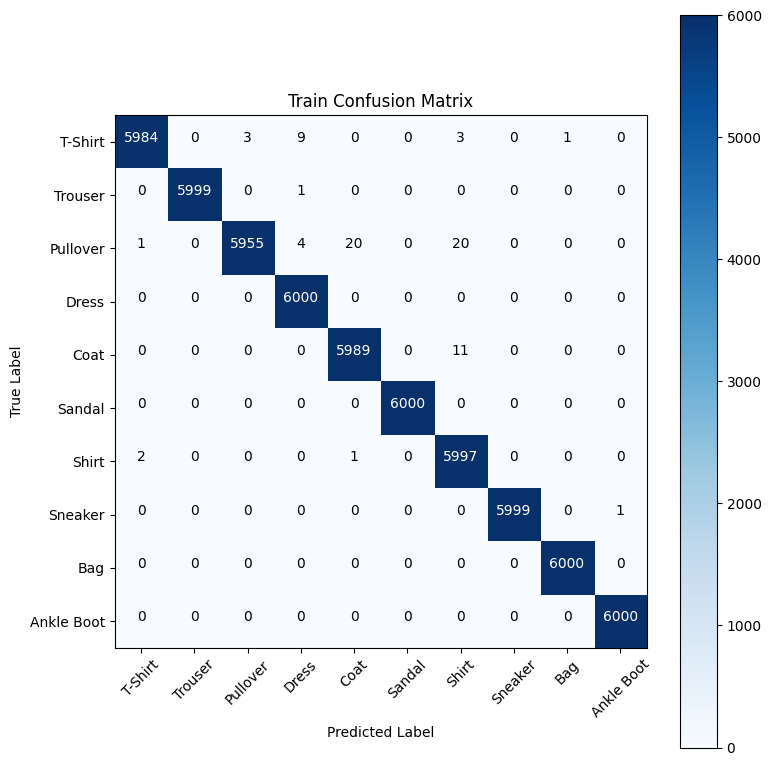

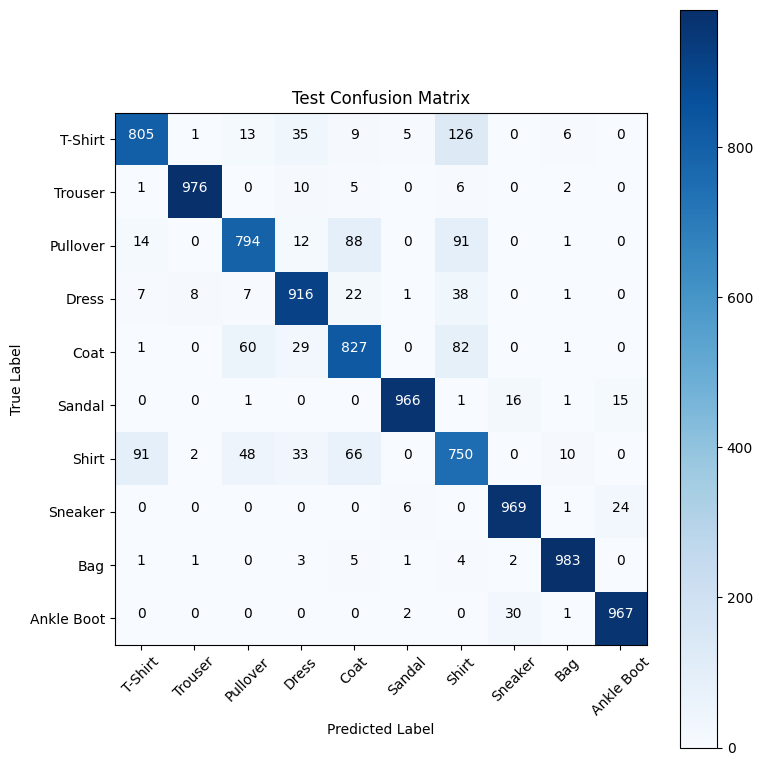

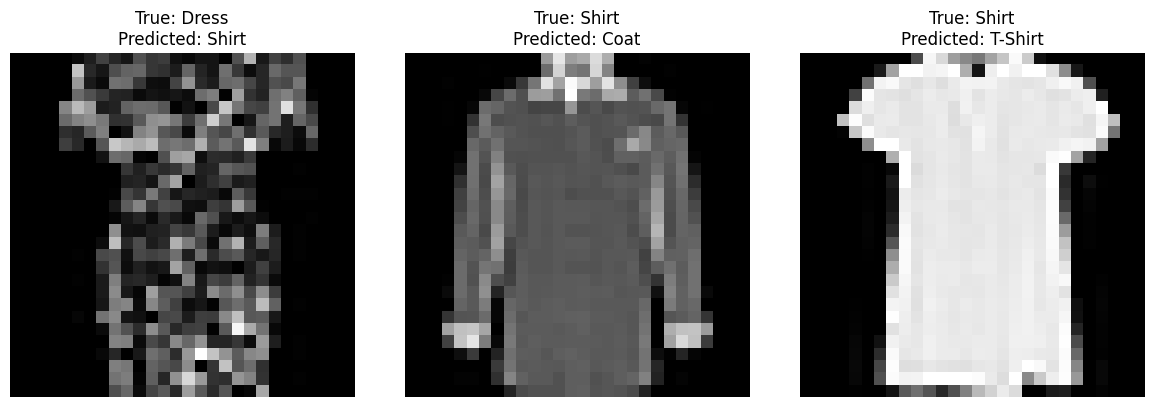

Train Accuracy: 0.9987
Test Accuracy: 0.8953


In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import random

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Add numbers to the confusion matrix
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()

# Function to get the predictions for a dataset
def get_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(target.cpu().numpy())
    return predictions, true_labels


# Get the predictions for the train and test datasets
train_predictions, train_true_labels = get_predictions(model, train_loader, device)
test_predictions, test_true_labels = get_predictions(model, test_loader, device)


# Plot the confusion matrix for the train dataset with numbers
cm_train = confusion_matrix(train_true_labels, train_predictions)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm_train, classes=list(labels_map.values()), normalize=False, title='Train Confusion Matrix')
plt.show()

# Plot the confusion matrix for the test dataset with numbers
cm_test = confusion_matrix(test_true_labels, test_predictions)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm_test, classes=list(labels_map.values()), normalize=False, title='Test Confusion Matrix')
plt.show()

# Plot 3 random examples from the wrong predictions
wrong_predictions = [i for i, (p, t) in enumerate(zip(test_predictions, test_true_labels)) if p != t]
random_indices = random.sample(wrong_predictions, 3)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, idx in enumerate(random_indices):
    img, _ = test_data[idx]
    true_label = test_true_labels[idx]
    predicted_label = test_predictions[idx]
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].set_title(f"True: {labels_map[true_label]}\nPredicted: {labels_map[predicted_label]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()
# Calculate train and test accuracy
train_accuracy = accuracy_score(train_true_labels, train_predictions)
test_accuracy = accuracy_score(test_true_labels, test_predictions)

# Print train and test accuracy
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")